# Divergence Operator

The divergence is the integral of a flux through a closed surface as that enclosed volume shrinks to a point. Since we have discretized and no longer have continuous functions, we cannot fully take the limit to a point; instead, we approximate it around some (finite!) volume: *a cell*. The flux out of the surface ($\vec{j} \cdot \vec{n}$) is actually how we discretized $\vec{j}$ onto our mesh (i.e. $\bf{j}$) except that the face normal points out of the cell (rather than in the axes direction). After fixing the direction of the face normal (multiplying by $\pm 1$), we only need to calculate the face areas and cell volume to create the discrete divergence matrix.

# Building our operators: the Face Divergence

```{figure} ../images/divergence.png
:name: 22570c81
Geometrical definition of the divergence and the discretization.
```

## Implementation

Although this is a really helpful way to think about conceptually what is happening, the implementation of that would be a huge for loop over each cell. In practice, this would be slow, so instead, we will take advantage of linear algebra. Let's start by looking at this in 1 dimension using the SimPEG Mesh class. 

In [1]:
import numpy as np
import discretize
import matplotlib.pyplot as plt

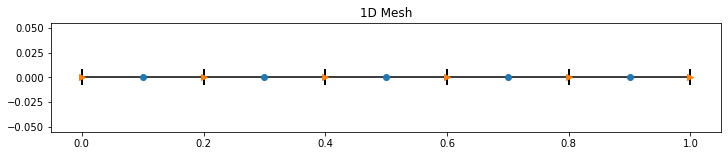

In [2]:
# define a 1D mesh
mesh1D = discretize.TensorMesh([5]) # with 5 cells 

fig, ax = plt.subplots(1,1, figsize=(12,2))
ax.plot(mesh1D.gridN, np.zeros(mesh1D.nN),'-k',marker='|',markeredgewidth=2, markersize=16)
ax.plot(mesh1D.gridCC,np.zeros(mesh1D.nC),'o')
ax.plot(mesh1D.gridFx,np.zeros(mesh1D.nFx),'>')
ax.set_title('1D Mesh');

The flux on the faces is [0. 1. 2. 2. 1. 0.]


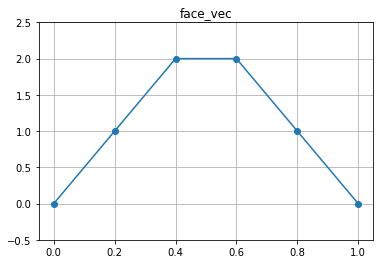

In [3]:
# and define a vector of fluxes that live on the faces of the 1D mesh
face_vec = np.r_[0., 1., 2., 2., 1., 0.]  # vector of fluxes that live on the faces of the mesh
print("The flux on the faces is {}".format(face_vec))

plt.plot(mesh1D.gridFx, face_vec, '-o')
plt.ylim([face_vec.min()-0.5, face_vec.max()+0.5])
plt.grid(which='both')
plt.title('face_vec');

Over a single cell, the divergence is 

$$
\nabla \cdot \vec{j}(p) = \lim_{v \to \{p\}} = \int \int_{S(v)} \frac{\vec{j}\cdot \vec{n}}{v} dS
$$

in 1D, this collapses to taking a single difference - how much is going out of the cell vs coming in? 

$$
\nabla \cdot \vec{j} \approx \frac{1}{v}(-j_{\text{left}} + j_{\text{right}})
$$

Since the normal of the x-face on the left side of the cell points in the positive x-direction, we multiply by -1 to get the flux going out of the cell. On the right, the normal defining the x-face is point out of the cell, so it is positive. 

In [4]:
# We can take the divergence over the entire mesh by looping over each cell
div_face_vec = np.zeros(mesh1D.nC) # allocate for each cell

for i in range(mesh1D.nC):  #  loop over each cell and 
    div_face_vec[i] = 1.0/mesh1D.cell_volumes[i] * (-face_vec[i] + face_vec[i+1])

print("The face div of the 1D flux is {}".format(div_face_vec))

The face div of the 1D flux is [ 5.  5.  0. -5. -5.]


Doing it as a for loop is easy to program for the first time, 
but is difficult to see what is going on and could be slow! 
Instead, we can build a face_divergence matrix (note: this is a silly way to do this!)

In [5]:
face_divergence = np.zeros([mesh1D.nC, mesh1D.nF]) # allocate space for a face div matrix
for i in range(mesh1D.nC):  #  loop over each cell
    face_divergence[i, [i, i+1]] = 1.0/mesh1D.cell_volumes[i] * np.r_[-1,+1]

print("The 1D face div matrix for this mesh is \n{}".format(face_divergence))

assert np.all(face_divergence.dot(face_vec) == div_face_vec)  # make sure we get the same result! 

print("\nThe face div of the 1D flux is still {}!".format(div_face_vec))

The 1D face div matrix for this mesh is 
[[-5.  5.  0.  0.  0.  0.]
 [ 0. -5.  5.  0.  0.  0.]
 [ 0.  0. -5.  5.  0.  0.]
 [ 0.  0.  0. -5.  5.  0.]
 [ 0.  0.  0.  0. -5.  5.]]

The face div of the 1D flux is still [ 5.  5.  0. -5. -5.]!


the above is still a loop... (and python is not a fan of loops). 
Also, if the mesh gets big, we are storing a lot of unnecessary zeros

In [6]:
print("There are {nnz} zeros (too many!) that we are storing".format(nnz = np.sum(face_divergence == 0)))

There are 20 zeros (too many!) that we are storing


### Working in Sparse

We will use instead *sparse* matrices instead. These are in scipy and act almost the same as numpy arrays (except they default to matrix multiplication), and they don't store all of those pesky zeros! We use [scipy.sparse](http://docs.scipy.org/doc/scipy/reference/sparse.html) to build these matrices. 

In [7]:
import scipy.sparse as sp
from SimPEG.utils import sdiag # we are often building sparse diagonal matrices, so we made a functio in SimPEG!

In [8]:
# construct differencing matrix with diagonals -1, +1
sparse_diff = sp.spdiags((np.ones((mesh1D.nC+1, 1))*[-1, 1]).T, [0, 1], mesh1D.nC, mesh1D.nC+1, format="csr")
print("the sparse differencing matrix is \n{}".format(sparse_diff.todense()))

# account for the volume
face_divergence_sparse = sdiag(1./mesh1D.cell_volumes) * sparse_diff  # account for volume 
print("\n and the face divergence is \n{}".format(face_divergence_sparse.todense()))

print("\n but now we are only storing {nnz} nonzeros".format(nnz=face_divergence_sparse.nnz))

assert np.all(face_divergence_sparse.dot(face_vec) == div_face_vec) 
print("\n and we get the same answer! {}".format(face_divergence_sparse * face_vec))

the sparse differencing matrix is 
[[-1.  1.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0. -1.  1.]]

 and the face divergence is 
[[-5.  5.  0.  0.  0.  0.]
 [ 0. -5.  5.  0.  0.  0.]
 [ 0.  0. -5.  5.  0.  0.]
 [ 0.  0.  0. -5.  5.  0.]
 [ 0.  0.  0.  0. -5.  5.]]

 but now we are only storing 10 nonzeros

 and we get the same answer! [ 5.  5.  0. -5. -5.]


In SimPEG, this is stored as the `face_divergence` property on the mesh

In [9]:
print(mesh1D.face_divergence * face_vec) # and still gives us the same answer!

[ 5.  5.  0. -5. -5.]


## Moving to 2D

To move up in dimensionality, we build a 2D mesh which has both x and y faces

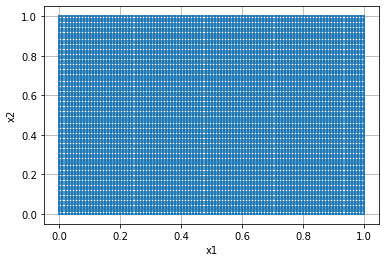

In [10]:
mesh2D = discretize.TensorMesh([100, 80])
mesh2D.plot_grid()
plt.axis('tight');

We define 2 face functions, one in the x-direction and one in the y-direction. Here, we choose to work with sine functions as the continuous divergence is easy to compute, meaning we can test it!

There are 8080 x-faces and 8100 y-faces, so the length of the face function, j, is 16180


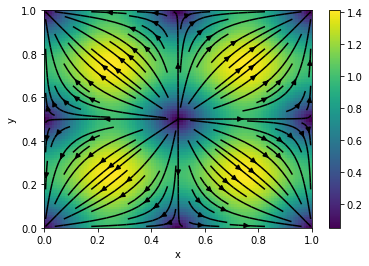

In [14]:
jx_fct = lambda x, y: -np.sin(2.*np.pi*x)
jy_fct = lambda x, y: -np.sin(2.*np.pi*y)

jx_vec = jx_fct(mesh2D.gridFx[:,0], mesh2D.gridFx[:,1])
jy_vec = jy_fct(mesh2D.gridFy[:,0], mesh2D.gridFy[:,1])

j_vec = np.r_[jx_vec, jy_vec]

print("There are {nFx} x-faces and {nFy} y-faces, so the length of the "
      "face function, j, is {lenj}".format(
        nFx=mesh2D.nFx, 
        nFy=mesh2D.nFy,
        lenj=len(j_vec)
     ))

plt.colorbar(mesh2D.plot_image(j_vec, 'F', view='vec')[0]);

### But first... what does the matrix look like?

Now, we know that we do not want to loop over each of the cells and instead want to work with matrix-vector products. In this case, each row of the divergence matrix should pick out the two relevant faces in the x-direction and two in the y-direction (4 total). 

When we unwrap our face function, we unwrap using column major ordering, so all of the x-faces are adjacent to one another, while the y-faces are separated by the number of cells in the x-direction (see [mesh.ipynb](mesh.ipynb) for more details!). 

When we plot the divergence matrix, there will be 4 "diagonals", 
- 2 that are due to the x-contribution
- 2 that are due to the y-contribution

Here, we define a small 2D mesh so that it is easier to see the matrix structure. 

In [17]:
small_mesh2D = discretize.TensorMesh([3, 4])

print("Each y-face is {} entries apart".format(small_mesh2D.shape_cells[0]))
print("and the total number of x-faces is {}".format(small_mesh2D.nFx))
print("So in the first row of the face_divergence, we have non-zero entries at \n{}".format(
        small_mesh2D.face_divergence[0,:]))

Each y-face is 3 entries apart
and the total number of x-faces is 16
So in the first row of the face_divergence, we have non-zero entries at 
  (0, 0)	-3.0
  (0, 1)	3.0
  (0, 16)	-4.0
  (0, 19)	4.0


Now, lets look at the matrix structure

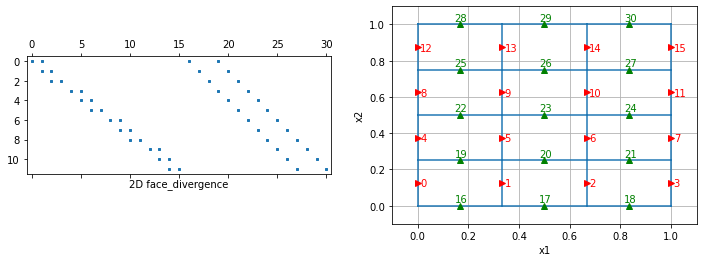

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

# plot the non-zero entries in the face_divergence
ax[0].spy(small_mesh2D.face_divergence, ms=2)
ax[0].set_xlabel('2D face_divergence')
small_mesh2D.plot_grid(ax=ax[1])

# Number the faces and plot. (We should really add this to SimPEG... pull request anyone!?)
xys = zip(
    small_mesh2D.gridFx[:,0], 
    small_mesh2D.gridFx[:,1], 
    range(small_mesh2D.nFx)
)
for x,y,ii in xys:
    ax[1].plot(x, y, 'r>')
    ax[1].text(x+0.01, y-0.02, ii, color='r')

xys = zip(
    small_mesh2D.gridFy[:,0], 
    small_mesh2D.gridFy[:,1], 
    range(small_mesh2D.nFy)
)
for x,y,ii in xys:
    ax[1].plot(x, y, 'g^')
    ax[1].text(x-0.02, y+0.02, ii+small_mesh2D.nFx, color='g')
ax[1].set_xlim((-0.1,1.1));
ax[1].set_ylim((-0.1,1.1));

How did we construct the matrix? - Kronecker products. 
There is a handy identity that relates the vectorized face function to its matrix form ([see Wikipedia](https://en.wikipedia.org/wiki/Vectorization_(mathematics)#Compatibility_with_Kronecker_products))

$$
\text{vec}(AUB^\top) = (B \otimes A) \text{vec}(U)
$$

For the x-contribution:
- A is our 1D differential operator ([-1, +1] on the diagonals)
- U is $j_x$ (the x-face function as a matrix) 
- B is just an identity, so 

$$
\text{Div}_x \text{vec}(j_x) = (I \otimes Div_{1D}) \text{vec}(j_x)
$$

For the y-contribution: 
- A is just an identity!
- U is $j_y$ (the y-face function as a matrix) 
- B is our 1D differential operator ([-1, +1] on the diagonals), so

$$
\text{Div}_y \text{vec}(j_y) = (\text{Div}_{1D} \otimes I) \text{vec}(j_y)
$$

$$
\text{Div} \cdot j  = \text{Div}_x \cdot j_x + \text{Div}_y \cdot j_y = [\text{Div}_x, \text{Div}_y] \cdot [j_x; j_y]
$$

And $j$ is just $[j_x; j_y]$, so we can horizontally stack $\text{Div}_x$, $\text{Div}_y$

$$
\text{Div} = [\text{Div}_x, \text{Div}_y]
$$

You can check this out in the SimPEG docs by running **small_mesh2D.face_divergence??**

In [24]:
# check out the code!
small_mesh2D.face_divergence??

Type:        property
String form: <property object at 0x7fd5e03cb450>
Source:     
# small_mesh2D.face_divergence.fget
@property
def face_divergence(self):
    if getattr(self, "_face_divergence", None) is None:
        # Get the stencil of +1, -1's
        D = self._face_divergence_stencil
        # Compute areas of cell faces & volumes
        S = self.face_areas
        V = self.cell_volumes
        self._face_divergence = sdiag(1 / V) * D * sdiag(S)
    return self._face_divergence


Now that we have a discrete divergence, lets check out the divergence of  the face function we defined earlier. 

/opt/anaconda3/envs/simpeg/lib/python3.8/site-packages/discretize/base/base_tensor_mesh.py:785: FutureWarning: The zerosOutside keyword argument has been deprecated, please use zeros_outside. This will be removed in discretize 1.0.0
  warnings.warn(


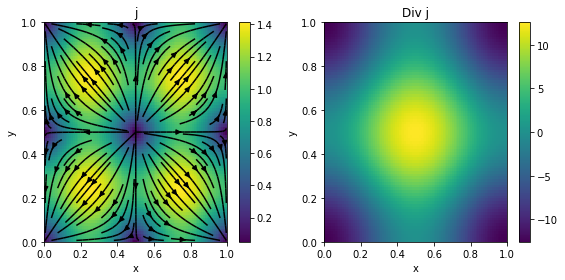

In [19]:
Div_j = mesh2D.face_divergence * j_vec

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt.colorbar(mesh2D.plot_image(j_vec, 'F', view='vec', ax=ax[0])[0],ax=ax[0])
plt.colorbar(mesh2D.plot_image(Div_j, ax=ax[1])[0],ax=ax[1])

ax[0].set_title('j')
ax[1].set_title('Div j')
plt.tight_layout()

### Are we right??

Since we chose a simple function,

$$
\vec{j} = - \sin(2\pi x) \hat{x} - \sin(2\pi y) \hat{y} 
$$

we know the continuous divergence...

$$
\nabla \cdot \vec{j} = -2\pi (\cos(2\pi x) + \cos(2\pi y))
$$

So lets plot it and take a look

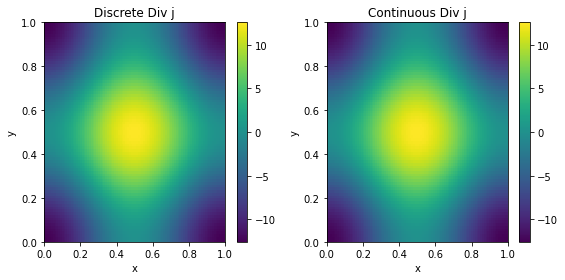

In [21]:
# from earlier
# jx_fct = lambda x, y: -np.sin(2*np.pi*x)
# jy_fct = lambda x, y: -np.sin(2*np.pi*y)

sol = lambda x, y: -2*np.pi*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y))

cont_div_j = sol(mesh2D.gridCC[:,0], mesh2D.gridCC[:,1])

Div_j = mesh2D.face_divergence * j_vec

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt.colorbar(mesh2D.plot_image(Div_j, ax=ax[0])[0],ax=ax[0])
plt.colorbar(mesh2D.plot_image(cont_div_j, ax=ax[1])[0],ax=ax[1])

ax[0].set_title('Discrete Div j')
ax[1].set_title('Continuous Div j')
plt.tight_layout()

Those look similar! 🚀

### Order Test

We can do better than just an eye-ball comparison - since we are using a a staggered grid, with centered differences, the discretization should be second-order ($\mathcal{O}(h^2)$). That is, as we refine the mesh, our approximation of the divergence should improve by a factor of 2. 

SimPEG has a number of testing functions for 
[derivatives](http://docs.simpeg.xyz/content/api_core/api_Tests.html#SimPEG.Tests.checkDerivative)
and 
[order of convergence](http://docs.simpeg.xyz/content/api_core/api_Tests.html#SimPEG.Tests.OrderTest) 
to make our lives easier!

In [23]:
import unittest
from discretize.tests import OrderTest

jx = lambda x, y: -np.sin(2*np.pi*x)
jy = lambda x, y: -np.sin(2*np.pi*y)
sol = lambda x, y: -2*np.pi*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y))

class Testify(OrderTest):
    meshDimension = 2
    
    def getError(self):
        j = np.r_[jx(self.M.gridFx[:,0], self.M.gridFx[:,1]),
                  jy(self.M.gridFy[:,0], self.M.gridFy[:,1])]
        num = self.M.face_divergence * j # numeric answer
        ans = sol(self.M.gridCC[:,0], self.M.gridCC[:,1]) # note M is a 2D mesh
        return np.linalg.norm((num - ans), np.inf) # look at the infinity norm 
                                                   # (as we refine the mesh, the number of cells 
                                                   # changes, so need to be careful if using a 2-norm)
    def test_order(self):
        self.orderTest()

# This just runs the unittest:
suite = unittest.TestLoader().loadTestsFromTestCase( Testify )
unittest.TextTestRunner().run( suite );

/opt/anaconda3/envs/simpeg/lib/python3.8/site-packages/discretize/utils/code_utils.py:247: FutureWarning: setupMesh has been deprecated, please use setup_mesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
.


uniformTensorMesh:  Order Test
_____________________________________________
   h  |    error    | e(i-1)/e(i) |  order
~~~~~~|~~~~~~~~~~~~~|~~~~~~~~~~~~~|~~~~~~~~~~
   4  |  8.86e-01   |
   8  |  2.96e-01   |   2.9914    |  1.5808
  16  |  7.90e-02   |   3.7462    |  1.9054
  32  |  2.01e-02   |   3.9364    |  1.9769
---------------------------------------------
Happy little convergence test!




----------------------------------------------------------------------
Ran 1 test in 0.010s

OK


Looks good - Second order convergence!

**Next up...**

In the [next notebook](weak-formulation.ipynb), we will explore how to use the weak formulation to discretize the DC equations. 